#Libraries

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from google.colab import drive

In [149]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Functions

In [150]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
tf.random.set_seed(7)

#Dataset

In [151]:
trial = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Agrimonia/Recap previous thesis/Agrimonia_Dataset_v_2_0_1.csv')
trial.head()

<ipython-input-151-378a04c23d50>:1: DtypeWarning: Columns (0,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  trial = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Agrimonia/Recap previous thesis/Agrimonia_Dataset_v_2_0_1.csv')


,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
0,1264,46.167852,9.87921,2016-01-01,290,6.200e+01,5.300e+01,NaN,NaN,8.263e+01,...,6.166e-01,8.359e-01,1.720e+00,3.906e-01,0.3832,5.892,3.998,1.234,112,17.0
1,1264,46.167852,9.87921,2016-01-02,290,7.300e+01,6.300e+01,NaN,NaN,1.017e+02,...,6.298e-01,8.372e-01,1.720e+00,3.911e-01,0.3832,5.892,3.997,1.234,112,17.0
2,1264,46.167852,9.87921,2016-01-03,290,4.400e+01,3.900e+01,NaN,NaN,6.626e+01,...,6.424e-01,8.384e-01,1.720e+00,3.916e-01,0.3832,5.892,3.997,1.234,112,17.0
3,1264,46.167852,9.87921,2016-01-04,290,3.100e+01,2.900e+01,NaN,NaN,6.331e+01,...,6.545e-01,8.396e-01,1.720e+00,3.923e-01,0.3832,5.892,3.997,1.234,112,17.0
4,1264,46.167852,9.87921,2016-01-05,290,2.700e+01,2.600e+01,NaN,NaN,7.553e+01,...,6.660e-01,8.409e-01,1.720e+00,3.931e-01,0.3832,5.892,3.997,1.233,112,17.0


In [152]:
trial = trial[trial["IDStations"]==1266]
trial.head()

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
4384,1266,45.233494,9.66625,2016-01-01,65,5.200e+01,NaN,NaN,3.220e+01,3.621e+01,...,9.749e+00,1.922e+00,3.844e+00,9.099e-01,513.5,255.2,1.548,2.084,112,17.0
4385,1266,45.233494,9.66625,2016-01-02,65,3.900e+01,NaN,NaN,1.460e+01,2.972e+01,...,9.792e+00,1.925e+00,3.832e+00,9.082e-01,514.0,255.1,1.548,2.084,112,17.0
4386,1266,45.233494,9.66625,2016-01-03,65,2.600e+01,NaN,NaN,1.120e+01,2.827e+01,...,9.832e+00,1.928e+00,3.821e+00,9.067e-01,514.5,255.1,1.548,2.084,112,17.0
4387,1266,45.233494,9.66625,2016-01-04,65,2.900e+01,NaN,NaN,1.080e+01,2.462e+01,...,9.869e+00,1.931e+00,3.809e+00,9.054e-01,515.0,255.0,1.548,2.083,112,17.0
4388,1266,45.233494,9.66625,2016-01-05,65,3.400e+01,NaN,NaN,1.510e+01,3.484e+01,...,9.903e+00,1.933e+00,3.797e+00,9.042e-01,515.5,254.9,1.548,2.083,112,17.0


In [153]:
#df['IDStations'] = df['IDStations'].astype(float)
trial['AQ_pm10'] = trial['AQ_pm10'].astype(float)
trial['AQ_nh3'] = trial['AQ_nh3'].astype(float)
trial['AQ_nox'] = trial['AQ_nox'].astype(float)
trial['AQ_no2'] = trial['AQ_no2'].astype(float)

trial['EM_nh3_livestock_mm'] = trial['EM_nh3_livestock_mm'].astype(float)
trial['EM_nh3_agr_soils'] = trial['EM_nh3_agr_soils'].astype(float)
trial['EM_nh3_agr_waste_burn'] = trial['EM_nh3_agr_waste_burn'].astype(float)
trial['EM_nh3_sum'] = trial['EM_nh3_sum'].astype(float)
trial['EM_nox_traffic'] = trial['EM_nox_traffic'].astype(float)
trial['EM_nox_sum'] = trial['EM_nox_sum'].astype(float)
trial['EM_so2_sum'] = trial['EM_so2_sum'].astype(float)
trial['LI_pigs'] = trial['LI_pigs'].astype(float)
trial['LI_bovine'] = trial['LI_bovine'].astype(float)

In [154]:
trial.dropna(inplace=True)
trial.head()

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
4384,1266,45.233494,9.66625,2016-01-01,65,52.0,NaN,NaN,32.2,36.21,...,9.749,1.922,3.844,0.9099,513.5,255.2,1.548,2.084,112,17.0
4385,1266,45.233494,9.66625,2016-01-02,65,39.0,NaN,NaN,14.6,29.72,...,9.792,1.925,3.832,0.9082,514.0,255.1,1.548,2.084,112,17.0
4386,1266,45.233494,9.66625,2016-01-03,65,26.0,NaN,NaN,11.2,28.27,...,9.832,1.928,3.821,0.9067,514.5,255.1,1.548,2.084,112,17.0
4387,1266,45.233494,9.66625,2016-01-04,65,29.0,NaN,NaN,10.8,24.62,...,9.869,1.931,3.809,0.9054,515.0,255.0,1.548,2.083,112,17.0
4388,1266,45.233494,9.66625,2016-01-05,65,34.0,NaN,NaN,15.1,34.84,...,9.903,1.933,3.797,0.9042,515.5,254.9,1.548,2.083,112,17.0


In [155]:
columns_to_convert = ['AQ_pm10','Latitude', 'Longitude', 'Altitude', 'WE_temp_2m', 'WE_wind_speed_10m_mean', 'WE_wind_speed_10m_max', 'WE_tot_precipitation', 'WE_precipitation_t', 'WE_surface_pressure', 'WE_solar_radiation', 'WE_rh_min', 'WE_rh_mean', 'WE_rh_max', 'WE_wind_speed_100m_max', 'WE_blh_layer_max', 'WE_blh_layer_min', 'EM_nh3_livestock_mm', 'EM_nh3_agr_soils', 'EM_nh3_agr_waste_burn', 'EM_nh3_sum', 'EM_nox_traffic', 'EM_nox_sum', 'EM_so2_sum', 'LI_pigs', 'LI_bovine', 'LA_hvi', 'LA_lvi', 'LA_land_use', 'LA_soil_use']
bumpy_array = trial[columns_to_convert].values
dataset= bumpy_array

print(type(bumpy_array))
print(dataset)

Output streaming troncato alle ultime 5000 righe.
 [ 5.000e+00  4.523e+01  9.666e+00  6.500e+01  1.980e+01  1.761e+00
   2.900e+00  5.328e-02  0.000e+00  1.012e+05  1.852e+07  8.154e+01
   8.940e+01  9.723e+01  6.649e+00  1.650e+03  4.949e+01  2.695e+01
   3.167e+00  9.559e-02  3.033e+01  2.652e+00  3.996e+00  4.985e-01
   5.721e+02  2.484e+02  2.163e+00  2.646e+00  1.120e+02  1.700e+01]
 [ 1.800e+01  4.523e+01  9.666e+00  6.500e+01  2.062e+01  2.001e+00
   2.876e+00  1.450e-03  0.000e+00  1.016e+05  1.888e+07  8.235e+01
   8.784e+01  9.396e+01  4.514e+00  1.544e+03  3.797e+01  2.698e+01
   3.082e+00  1.003e-01  3.028e+01  2.636e+00  3.998e+00  5.013e-01
   5.721e+02  2.484e+02  2.154e+00  2.637e+00  1.120e+02  1.700e+01]
 [ 2.800e+01  4.523e+01  9.666e+00  6.500e+01  2.209e+01  1.610e+00
   2.382e+00  2.741e-06  0.000e+00  1.017e+05  1.969e+07  8.231e+01
   8.935e+01  9.648e+01  3.047e+00  1.087e+03  2.391e+01  2.702e+01
   2.997e+00  1.050e-01  3.024e+01  2.620e+00  3.999e+00  5.041e

In [156]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [157]:
# Set the desired precision for printing
np.set_printoptions(precision=3)
np.set_printoptions(threshold=np.inf)

# Print the rounded dataset
print(dataset)

[[3.611e-01 0.000e+00 0.000e+00 0.000e+00 1.293e-01 8.544e-02 1.030e-01
  8.170e-06 0.000e+00 7.500e-01 2.029e-01 7.756e-01 8.817e-01 9.772e-01
  7.466e-02 6.968e-02 5.606e-03 2.718e-03 5.011e-03 3.146e-01 4.290e-03
  5.003e-01 6.568e-01 8.940e-01 5.316e-01 1.000e+00 1.179e-03 3.807e-03
  0.000e+00 1.000e+00]
 [2.708e-01 0.000e+00 0.000e+00 0.000e+00 9.238e-02 1.704e-01 1.669e-01
  9.632e-02 1.667e-01 5.682e-01 8.595e-03 9.541e-01 9.804e-01 9.917e-01
  1.936e-01 4.133e-02 5.778e-02 3.542e-03 5.880e-03 3.047e-01 5.208e-03
  5.021e-01 6.521e-01 8.911e-01 5.351e-01 9.890e-01 1.179e-03 3.807e-03
  0.000e+00 1.000e+00]
 [1.806e-01 0.000e+00 0.000e+00 0.000e+00 1.325e-01 2.680e-01 2.940e-01
  5.059e-02 1.667e-01 3.636e-01 1.155e-01 9.004e-01 9.472e-01 9.924e-01
  3.524e-01 7.090e-02 1.578e-01 4.242e-03 6.701e-03 2.940e-01 6.062e-03
  5.038e-01 6.478e-01 8.886e-01 5.387e-01 9.890e-01 1.179e-03 3.807e-03
  0.000e+00 1.000e+00]
 [2.014e-01 0.000e+00 0.000e+00 0.000e+00 1.214e-01 1.433e-01 2.930

#Train and test

In [158]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

800 395


In [159]:
# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)

In [160]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))


In [161]:
print(len(trainX))
print(len(trainY))

798
798


In [162]:
print(trainX.shape[1])
print(trainY.shape)


1
(798,)


In [163]:
print(trainX)

[[[3.611e-01 0.000e+00 0.000e+00 0.000e+00 1.293e-01 8.544e-02 1.030e-01
   8.170e-06 0.000e+00 7.500e-01 2.029e-01 7.756e-01 8.817e-01 9.772e-01
   7.466e-02 6.968e-02 5.606e-03 2.718e-03 5.011e-03 3.146e-01 4.290e-03
   5.003e-01 6.568e-01 8.940e-01 5.316e-01 1.000e+00 1.179e-03 3.807e-03
   0.000e+00 1.000e+00]]

 [[2.708e-01 0.000e+00 0.000e+00 0.000e+00 9.238e-02 1.704e-01 1.669e-01
   9.632e-02 1.667e-01 5.682e-01 8.595e-03 9.541e-01 9.804e-01 9.917e-01
   1.936e-01 4.133e-02 5.778e-02 3.542e-03 5.880e-03 3.047e-01 5.208e-03
   5.021e-01 6.521e-01 8.911e-01 5.351e-01 9.890e-01 1.179e-03 3.807e-03
   0.000e+00 1.000e+00]]

 [[1.806e-01 0.000e+00 0.000e+00 0.000e+00 1.325e-01 2.680e-01 2.940e-01
   5.059e-02 1.667e-01 3.636e-01 1.155e-01 9.004e-01 9.472e-01 9.924e-01
   3.524e-01 7.090e-02 1.578e-01 4.242e-03 6.701e-03 2.940e-01 6.062e-03
   5.038e-01 6.478e-01 8.886e-01 5.387e-01 9.890e-01 1.179e-03 3.807e-03
   0.000e+00 1.000e+00]]

 [[2.014e-01 0.000e+00 0.000e+00 0.000e+00 1.2

In [164]:
print(trainY)

[0.271 0.181 0.201 0.236 0.264 0.292 0.41  0.312 0.271 0.222 0.062 0.028
 0.174 0.16  0.132 0.042 0.194 0.306 0.444 0.583 0.722 0.722 0.882 0.938
 0.625 0.604 0.736 0.701 0.826 0.403 0.306 0.319 0.153 0.049 0.181 0.34
 0.299 0.215 0.222 0.035 0.104 0.215 0.271 0.306 0.278 0.132 0.104 0.208
 0.229 0.188 0.215 0.41  0.486 0.208 0.125 0.16  0.097 0.076 0.069 0.222
 0.194 0.021 0.104 0.104 0.201 0.278 0.354 0.347 0.278 0.271 0.271 0.403
 0.382 0.278 0.111 0.104 0.049 0.139 0.208 0.09  0.146 0.104 0.125 0.09
 0.104 0.16  0.201 0.188 0.222 0.042 0.007 0.104 0.125 0.139 0.146 0.146
 0.104 0.104 0.118 0.083 0.097 0.16  0.201 0.167 0.16  0.319 0.174 0.035
 0.146 0.153 0.076 0.007 0.028 0.097 0.076 0.09  0.132 0.111 0.069 0.118
 0.16  0.306 0.215 0.153 0.125 0.083 0.146 0.153 0.132 0.104 0.118 0.153
 0.229 0.208 0.229 0.16  0.174 0.083 0.097 0.062 0.069 0.097 0.111 0.118
 0.125 0.111 0.125 0.194 0.306 0.361 0.312 0.132 0.069 0.139 0.174 0.188
 0.167 0.236 0.16  0.104 0.208 0.188 0.215 0.167 0.21

In [165]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))


In [166]:
print(trainX)

[[[3.611e-01 0.000e+00 0.000e+00 0.000e+00 1.293e-01 8.544e-02 1.030e-01
   8.170e-06 0.000e+00 7.500e-01 2.029e-01 7.756e-01 8.817e-01 9.772e-01
   7.466e-02 6.968e-02 5.606e-03 2.718e-03 5.011e-03 3.146e-01 4.290e-03
   5.003e-01 6.568e-01 8.940e-01 5.316e-01 1.000e+00 1.179e-03 3.807e-03
   0.000e+00 1.000e+00]]

 [[2.708e-01 0.000e+00 0.000e+00 0.000e+00 9.238e-02 1.704e-01 1.669e-01
   9.632e-02 1.667e-01 5.682e-01 8.595e-03 9.541e-01 9.804e-01 9.917e-01
   1.936e-01 4.133e-02 5.778e-02 3.542e-03 5.880e-03 3.047e-01 5.208e-03
   5.021e-01 6.521e-01 8.911e-01 5.351e-01 9.890e-01 1.179e-03 3.807e-03
   0.000e+00 1.000e+00]]

 [[1.806e-01 0.000e+00 0.000e+00 0.000e+00 1.325e-01 2.680e-01 2.940e-01
   5.059e-02 1.667e-01 3.636e-01 1.155e-01 9.004e-01 9.472e-01 9.924e-01
   3.524e-01 7.090e-02 1.578e-01 4.242e-03 6.701e-03 2.940e-01 6.062e-03
   5.038e-01 6.478e-01 8.886e-01 5.387e-01 9.890e-01 1.179e-03 3.807e-03
   0.000e+00 1.000e+00]]

 [[2.014e-01 0.000e+00 0.000e+00 0.000e+00 1.2

In [167]:
print(trainY)

[0.271 0.181 0.201 0.236 0.264 0.292 0.41  0.312 0.271 0.222 0.062 0.028
 0.174 0.16  0.132 0.042 0.194 0.306 0.444 0.583 0.722 0.722 0.882 0.938
 0.625 0.604 0.736 0.701 0.826 0.403 0.306 0.319 0.153 0.049 0.181 0.34
 0.299 0.215 0.222 0.035 0.104 0.215 0.271 0.306 0.278 0.132 0.104 0.208
 0.229 0.188 0.215 0.41  0.486 0.208 0.125 0.16  0.097 0.076 0.069 0.222
 0.194 0.021 0.104 0.104 0.201 0.278 0.354 0.347 0.278 0.271 0.271 0.403
 0.382 0.278 0.111 0.104 0.049 0.139 0.208 0.09  0.146 0.104 0.125 0.09
 0.104 0.16  0.201 0.188 0.222 0.042 0.007 0.104 0.125 0.139 0.146 0.146
 0.104 0.104 0.118 0.083 0.097 0.16  0.201 0.167 0.16  0.319 0.174 0.035
 0.146 0.153 0.076 0.007 0.028 0.097 0.076 0.09  0.132 0.111 0.069 0.118
 0.16  0.306 0.215 0.153 0.125 0.083 0.146 0.153 0.132 0.104 0.118 0.153
 0.229 0.208 0.229 0.16  0.174 0.083 0.097 0.062 0.069 0.097 0.111 0.118
 0.125 0.111 0.125 0.194 0.306 0.361 0.312 0.132 0.069 0.139 0.174 0.188
 0.167 0.236 0.16  0.104 0.208 0.188 0.215 0.167 0.21

In [168]:
print(len(trainX))
print(len(trainY))

798
798


In [169]:
look_back = 1

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
798/798 - 4s - loss: 0.0174 - 4s/epoch - 6ms/step
Epoch 2/100
798/798 - 2s - loss: 0.0117 - 2s/epoch - 3ms/step
Epoch 3/100
798/798 - 2s - loss: 0.0103 - 2s/epoch - 3ms/step
Epoch 4/100
798/798 - 1s - loss: 0.0093 - 1s/epoch - 2ms/step
Epoch 5/100
798/798 - 1s - loss: 0.0085 - 1s/epoch - 2ms/step
Epoch 6/100
798/798 - 1s - loss: 0.0078 - 1s/epoch - 2ms/step
Epoch 7/100
798/798 - 1s - loss: 0.0073 - 1s/epoch - 2ms/step
Epoch 8/100
798/798 - 1s - loss: 0.0073 - 1s/epoch - 2ms/step
Epoch 9/100
798/798 - 1s - loss: 0.0069 - 1s/epoch - 2ms/step
Epoch 10/100
798/798 - 1s - loss: 0.0067 - 1s/epoch - 2ms/step
Epoch 11/100
798/798 - 2s - loss: 0.0066 - 2s/epoch - 2ms/step
Epoch 12/100
798/798 - 2s - loss: 0.0067 - 2s/epoch - 3ms/step
Epoch 13/100
798/798 - 2s - loss: 0.0066 - 2s/epoch - 2ms/step
Epoch 14/100
798/798 - 1s - loss: 0.0066 - 1s/epoch - 2ms/step
Epoch 15/100
798/798 - 1s - loss: 0.0065 - 1s/epoch - 2ms/step
Epoch 16/100
798/798 - 1s - loss: 0.0063 - 1s/epoch - 2ms/step
E

In [170]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


13/13 [==============================] - 0s 2ms/step


In [171]:
print(trainPredict.shape)
print(testPredict.shape)

(798, 1)
(393, 1)


In [172]:
print(trainY.shape)
print(testY.shape)

(798,)
(393,)


In [173]:
trainY = trainY.reshape(798, 1)
testY  = testY.reshape(393,1)

In [174]:
print(trainY.shape)
print(testY.shape)

(798, 1)
(393, 1)


In [175]:
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.07 RMSE
Test Score: 0.07 RMSE


In [186]:
trainMAE = mean_absolute_error(trainY, trainPredict)
testMAE = mean_absolute_error(testY, testPredict)

# Calculate R2 score
trainR2 = r2_score(trainY, trainPredict)
testR2 = r2_score(testY, testPredict)

# Calculate RMSE
trainRMSE = np.sqrt(mean_squared_error(trainY, trainPredict))
testRMSE = np.sqrt(mean_squared_error(testY, testPredict))

# Calculate variance
trainVariance = np.var(trainPredict)
testVariance = np.var(testPredict)

# Print the results
print('Train MAE: %.2f' % trainMAE)
print('Train R2 Score: %.2f' % trainR2)
print('Train RMSE: %.2f' % trainRMSE)
print('Train Variance: %.2f' % trainVariance)

print('Test MAE: %.2f' % testMAE)
print('Test R2 Score: %.2f' % testR2)
print('Test RMSE: %.2f' % testRMSE)
print('Test Variance: %.2f' % testVariance)

Train MAE: 0.06
Train R2 Score: 0.73
Train RMSE: 0.07
Train Variance: 0.02
Test MAE: 0.05
Test R2 Score: 0.64
Test RMSE: 0.07
Test Variance: 0.01


#Plotting

In [176]:
print(trainY.shape)
print(testY.shape)
print(trainPredict.shape)
print(testPredict.shape)

(798, 1)
(393, 1)
(798, 1)
(393, 1)


In [177]:
trainY = trainY.reshape(-1)
testY = testY.reshape(-1)
trainPredict = trainPredict.reshape(-1)
testPredict = testPredict.reshape(-1)

In [178]:
print(trainY.shape)
print(testY.shape)
print(trainPredict.shape)
print(testPredict.shape)

(798,)
(393,)
(798,)
(393,)


In [179]:
results = pd.DataFrame({'Actual': trainY, 'Predicted': trainPredict})


## Train

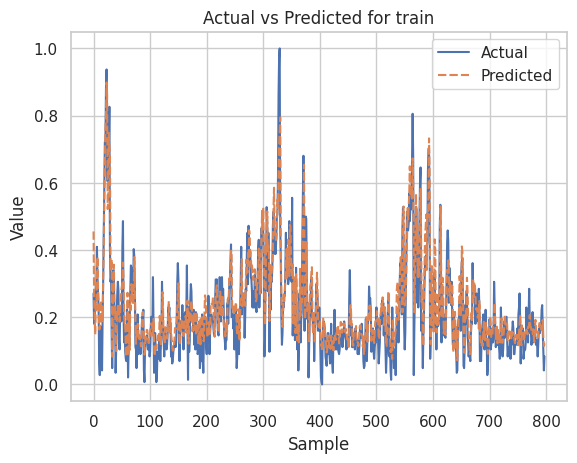

In [180]:
sns.set(style='whitegrid')
sns.lineplot(data=results)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted for train')
plt.show()

##Test

In [181]:
results = pd.DataFrame({'Actual': testY, 'Predicted': testPredict})

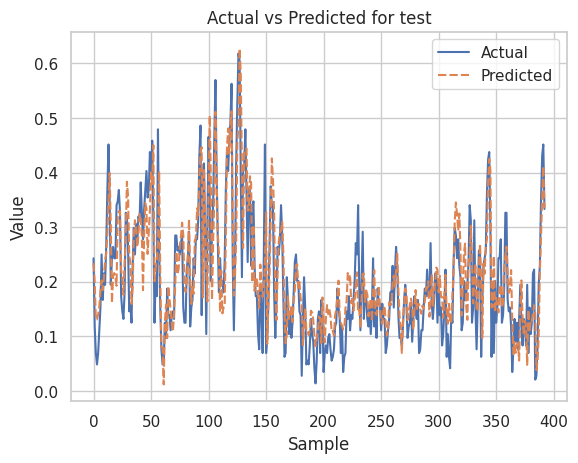

In [183]:
sns.set(style='whitegrid')
sns.lineplot(data=results)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted for test')
plt.show()